Walkthrough by Luke Polson (Mr P Solver) 
https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid14.ipynb

In [ ]:
%pip install numba
%pip install scipy
%pip install SciencePlots
%pip install matplotlib
%pip install numpy

In [46]:
import numpy as np
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(["science", "notebook", "grid"])
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

# 50 x 50 grid of spins
N = 50

# initiate random grid of spins
init_random = np.random.random((N, N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1 # make a lattice of spins where there are more negatives than positives


lattice_p = np.zeros((N, N))
lattice_p[init_random >= 0.25] = 1
lattice_p[init_random < 0.25] = -1  # make a lattice of spins where there are more positives than negatives


def get_energy(lattice):
    # gets the energy of each pixel via nearest neighbor
    # summation
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0) # convolve the lattice with the kernel
    return arr.sum()


get_energy(lattice_p)

np.float64(-2248.0)

In [47]:
# takes initial grid of spins, number of steps to run for
# and temperature BJ. Returns the total spin of all the
# atoms

@numba.njit("UniTuple(f8[:],2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for i in range(0,times-1):
        # 2. pick random point on array and flip spin 
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)
        spin_init = spin_arr[x][y] # initial spin
        spin_final = spin_init * -1 # flipped spin

        # compute the change in energy, using the equation
        # which multiplies energy by the nearest neighbours 
        E_init = 0
        E_final = 0
        if x>0:
            E_init += -spin_init * spin_arr[x-1][y] # spin_init is sigma^i, the neighbour is sigma^j
            E_final += -spin_final * spin_arr[x-1][y]
        if x<N-1:
            E_init += -spin_init * spin_arr[x+1][y]
            E_final += -spin_final * spin_arr[x+1][y]
        if y>0:
            E_init += -spin_init * spin_arr[x][y-1]
            E_final += -spin_final * spin_arr[x][y-1]
        if y<N-1:
            E_init += -spin_init * spin_arr[x][y+1]
            E_final += -spin_final * spin_arr[x][y+1]
        

        # 3/4 compute the change in energy, and change the
        # state with the desired probabilities
        dE = E_final - E_init
        # if the change in energy is positive, 
        if (dE > 0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x][y] = spin_final # flip the spin within the spin array
            energy +=dE
        elif (dE<=0):
            spin_arr[x][y] = spin_final
            energy += dE

        net_spins[i] = spin_arr.sum()
        net_energy[i] = energy
    return net_spins, net_energy




/opt/homebrew/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [48]:
# the initial energy of the lattice is gotten with get_energy
spins, energies = metropolis(lattice_n, 100000, 0.2, get_energy(lattice_n))

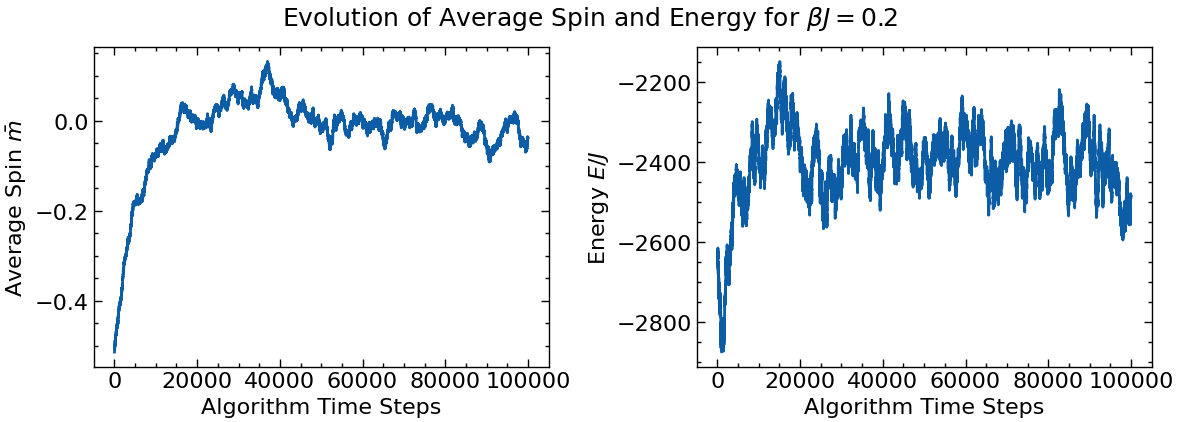

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.2', y=1.07, size=18)
plt.show()

In [50]:
# get the average energy(E/J) and spin (mbar) for many BJ
# values

def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**2 # need to divide by N*N because the lattice is NxN and we need to normalize
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds

BJs = np.arange(0.1,2,0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)


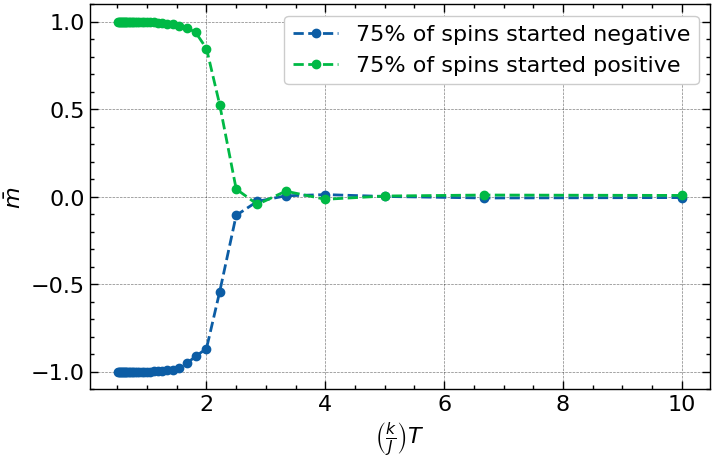

In [51]:
# can look at mbar as function of temperature T = 1/betasubk
# = J/betaJk

plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1 / BJs, ms_p, "o--", label="75% of spins started positive")
plt.xlabel(r"$\left(\frac{k}{J}\right)T$")
plt.ylabel(r"$\bar{m}$")
plt.legend(facecolor="white", framealpha=1)
plt.show()

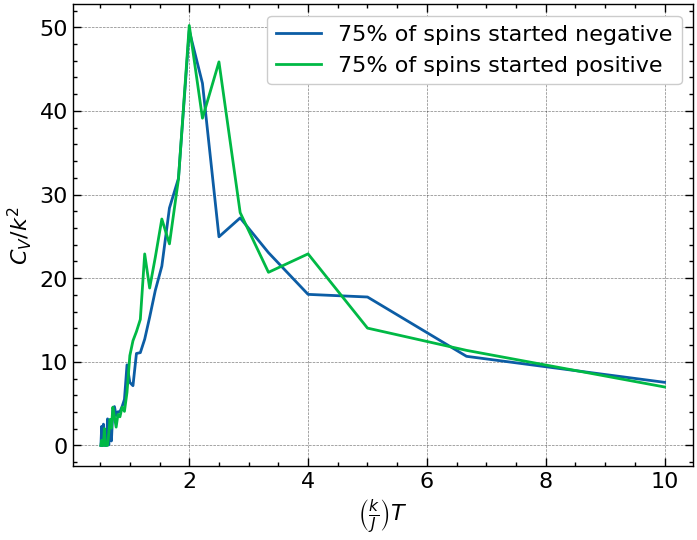

In [52]:
# heat capavity is standard deviation of energy / temp
# squared = std * bj^2 k^2

plt.plot(1 / BJs, E_stds_n * BJs, label="75% of spins started negative")
plt.plot(1 / BJs, E_stds_p * BJs, label="75% of spins started positive")
plt.xlabel(r"$\left(\frac{k}{J}\right)T$")
plt.ylabel(r"$C_V / k^2$")
plt.legend()
plt.show()